Processed read 0 after 0.00021910667419433594s
Processed read 1000000 after 9.010450839996338s


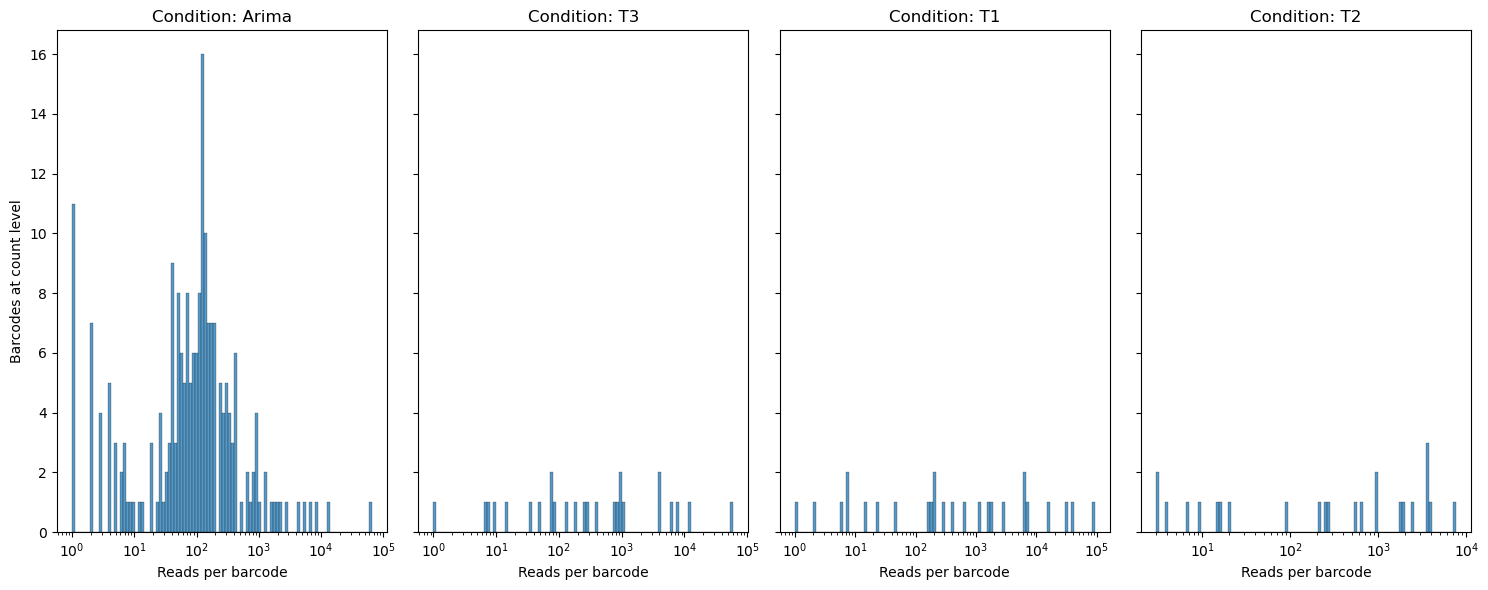

In [14]:
import polars as pl
import pysam
from pathlib import Path
from collections import defaultdict
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import time
def annotation_dict(filename, has_header, separator):
    df = pl.read_csv(filename, separator = separator, has_header = has_header)
    col1, col2 = df.columns[:2]
    return dict(zip(df[col1], df[col2]))


"""
To do this properly, we would need to have the bam file sorted by name, then iterate through blocks of read names.
We would then want to count the number of read blocks having a forward and reverse alignment.
"""

def alignment_distribution(filename: str,
                            condition_code: str = "",
                            cell_code: str = "",
                            record_code: str = "",
                            annotations: dict = {},
                            out_dir: str = ".",
                            head: int = None):
    counts = defaultdict(lambda: defaultdict(int))
    start = time.time()

    with pysam.AlignmentFile(filename) as alignments:
        cur_query_name = ""
        first, second = False, False
        count = False
        for i, record in enumerate(alignments):
            if i % 1000000 == 0:
                print(f"Processed read {i} after {time.time() - start}s")
            # Get the filename from the filename code
            condition = eval(condition_code, {'record':record, 'annotations':annotations})
            cell = eval(cell_code, {'record': record, 'annotations': annotations, 'condition':condition})
            # Keep the record if the record code is not supplied xor it is supplied and evals true
            count_read = bool(not record_code) ^ bool(record_code and eval(record_code, {'record': record, 'annotations': annotations, 'condition': condition, 'cell': cell}))
            
            if record.query_name != cur_query_name:
                if first and second:
                    counts[condition][cell] += 1
                cur_cell = cell
                first, second = False, False
            cur_query_name = record.query_name
            first = first or record.is_read1
            second = second or record.is_read2
            if head and i >= head:
                break
            
            
        path = Path(out_dir) / Path(filename)
        

    
    condition_cell_counts = defaultdict(list)
    for condition, condition_cells in counts.items():
        for cell, cell_count in condition_cells.items():
            condition_cell_counts["condition"].append(condition)
            condition_cell_counts["cell"].append(cell)
            condition_cell_counts["count"].append(cell_count)

    return pl.DataFrame(condition_cell_counts)

annotations = annotation_dict("240802_Arima.annot", has_header = False, separator = "\t")
condition_code = "annotations[record.query_name.split(':')[0]]"
cell_code = "record.query_name.split(':')[0]"
record_code = ""

if record_code: record_code = compile(record_code, '<string>', 'eval')
if condition_code: filename_code = compile(condition_code, '<string>', 'eval')
if cell_code: cell_code = compile(cell_code, '<string>', 'eval')

counts = alignment_distribution("240802.hic.reseq.merg.bbrd.q10.nsrt.bam",
                       condition_code,
                       cell_code,
                       record_code,
                       annotations,
                       head = int(1E6))

counts.write_csv("counts.tsv", separator = "\t", include_header = True)
counts = counts.to_pandas()

# Get the unique conditions
conditions = counts["condition"].unique()

# Set up the matplotlib figure with subplots, one per condition
fig, axes = plt.subplots(1, len(conditions), figsize=(15, 6), sharey=True)

# Plot a histogram for each condition
for ax, condition in zip(axes, conditions):
    subset = counts[counts["condition"] == condition]
    sns.histplot(subset["count"], ax=ax, log_scale=(True, False), bins = 100)
    ax.set_title(f"Condition: {condition}")
    ax.set_xlabel("Reads per barcode")
    ax.set_ylabel("Barcodes at count level")

plt.tight_layout()
plt.savefig("r1r2_per_barcode_per_condition.png")
